## Data preprocessing

cell_line_demuxlet
A549      1256
H838       876
H2228      758
HCC827     588
H1975      440
Name: count, dtype: int64
Dimensions data :  (3918, 11786)
View of AnnData object with n_obs × n_vars = 3918 × 1784
    obs: 'unaligned', 'aligned_unmapped', 'mapped_to_exon', 'mapped_to_intron', 'ambiguous_mapping', 'mapped_to_ERCC', 'mapped_to_MT', 'number_of_genes', 'total_count_per_cell', 'non_mt_percent', 'non_ribo_percent', 'outliers', 'is_cell_control', 'total_features_by_counts', 'log10_total_features_by_counts', 'total_counts', 'log10_total_counts', 'pct_counts_in_top_50_features', 'pct_counts_in_top_100_features', 'pct_counts_in_top_200_features', 'pct_counts_in_top_500_features', 'total_features', 'log10_total_features', 'pct_counts_top_50_features', 'pct_counts_top_100_features', 'pct_counts_top_200_features', 'pct_counts_top_500_features', 'cell_line', 'cell_line_demuxlet', 'demuxlet_cls'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg

C:\Users\mathi\anaconda3\envs\tda\lib\site-packages\scanpy\preprocessing\_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


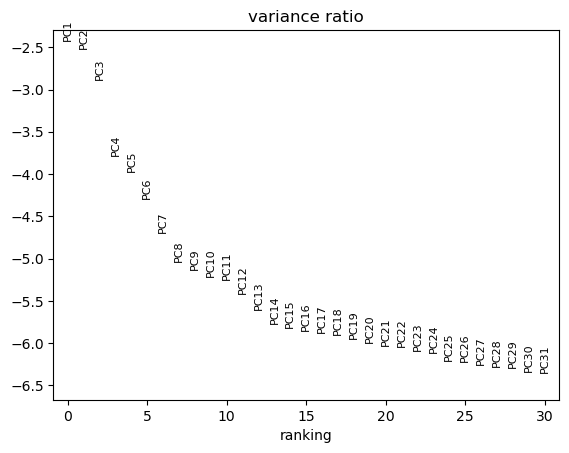

array([[-3.9457726e+00, -9.2206507e+00,  2.0222286e+01, ...,
         8.8885590e-02,  2.6416907e-03, -4.8541901e-01],
       [-3.4127007e+00, -4.3891897e+00,  1.8196064e+01, ...,
         1.3597934e+00, -1.0876460e+00,  2.7169594e-01],
       [ 2.3694241e+01, -7.8581963e+00, -2.3591566e+00, ...,
         2.6312685e+00, -5.7533860e-01,  8.7177181e-01],
       ...,
       [-6.9658357e-01,  1.4383985e+01, -9.6239561e-01, ...,
        -4.5467368e-01, -1.0405916e+00,  1.3792634e+00],
       [-1.5877130e+00,  1.6967482e+01, -1.6259260e+00, ...,
         2.5191774e+00, -6.2515438e-01,  2.3467333e+00],
       [ 2.0639902e+01, -6.1810417e+00, -3.2384000e+00, ...,
        -2.0098891e+00,  1.2411132e+00, -8.7000388e-01]], dtype=float32)

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

counts = pd.read_csv("data/sc_10x_5cl.count.csv")
metadata = pd.read_csv("data/sc_10x_5cl.metadata.csv")
## these are the 5 cell lines
print( metadata.cell_line_demuxlet.value_counts() )

# Create an AnnData object
adata = ad.AnnData(counts.T)  # need to transpose because I want the genes to be columns
adata.obs = metadata
print("Dimensions data : ", adata.X.shape)

# Normalize counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# Logarithmize the data
sc.pp.log1p(adata)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# Keep only those genes
adata = adata[:, adata.var.highly_variable]

# Check the dataset after filtering
print(adata)

# Run PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver="arpack")

# Visualize the PCA
sc.pl.pca_variance_ratio(adata, log=True)

# Compute the neighborhood graph
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

n_pcs = 40
adata.obsm["X_pca"][:, :n_pcs]

# ClusterGraph real labels

In [3]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import colormaps as cm
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from sklearn.preprocessing import StandardScaler

import clustergraph.clustergraph as cg
from clustergraph.utils import get_clusters_from_scikit
import clustergraph.plot_graph as pg

n_pcs = 40
X = adata.obsm["X_pca"][:, :n_pcs]
pred = np.array(metadata["cell_line_demuxlet"])

cluster_g = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(pred), X=X, metric_clusters="average"
)

# Coloring the graph
cluster_g.color_graph(
    node_color_labels=pred,
    node_palette=cm.get_cmap("tab10"),
)

cell_type_colors = {}

for n in cluster_g.Graph.nodes :
    color = cluster_g.Graph.nodes[n]["color"]
    label = list(cluster_g.Graph.nodes[n]['data_perc_labels'])[0]
    cell_type_colors[label] = color

legend_elements = [Patch(facecolor=color, label=label) for label, color in cell_type_colors.items()]

cell_type_colors

{'A549': '#1f77b4',
 'H1975': '#2ca02c',
 'H2228': '#9467bd',
 'H838': '#e377c2',
 'HCC827': '#bcbd22'}

# ClusterGraph with KMeans

In [4]:
model = KMeans(12, random_state=42)
pred_kmeans = model.fit_predict(X)
color_labels = np.array( [ cell_type_colors[label]  for label in pred  ] )

cluster_gk = cg.ClusterGraph(
    clusters=get_clusters_from_scikit(pred_kmeans), X=X, metric_clusters="average"
)

# Coloring the graph
cluster_gk.color_graph(
    node_color_labels=color_labels,
    node_palette=cm.get_cmap("tab20"),
)
legend_elements = [Patch(facecolor=color, label=label) for label, color in cell_type_colors.items()]

C:\Users\mathi\anaconda3\envs\tda\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Umap

In [5]:
import umap as um

uma15 = um.UMAP(n_neighbors=15, random_state=5)
X_umap_15 = uma15.fit_transform(X)

Text(0, 0.5, 'UMAP 2')

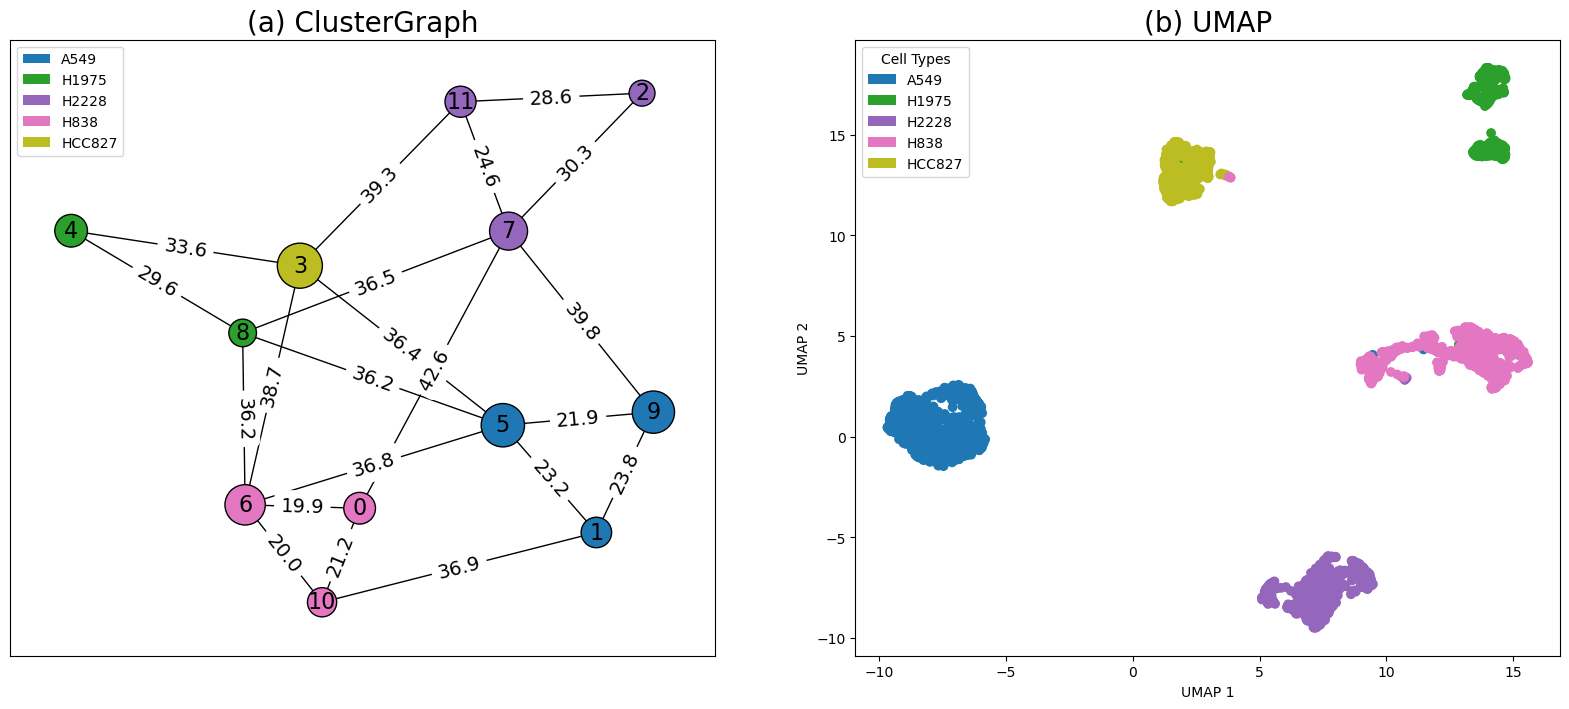

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

connectivity_graph = cluster_gk.prune_conn(nb_edge_pruned=45)  # 45 est top

pos = nx.kamada_kawai_layout(
    connectivity_graph, scale=1, center=(0, 0), weight="weight"
)

nx.draw_networkx_edges(connectivity_graph, pos=pos, ax=axs[0])

edge_labels = {
    (u, v): "{:.1f}".format(data["weight"])
    for u, v, data in connectivity_graph.edges(data=True)
}
nx.draw_networkx_edge_labels(
    connectivity_graph,
    pos,
    edge_labels=edge_labels,
    font_color="black",
    font_size=14,
    ax=axs[0],
)

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

node_colors = []
node_sizes = []
for node, data in connectivity_graph.nodes(data=True):
    data_perc_labels = data["data_perc_labels"]
    dominant_color = max(data_perc_labels, key=data_perc_labels.get)
    node_colors.append(dominant_color)
    node_sizes.append(data.get("size_plot", 1) * 3500)

nx.draw_networkx_nodes(
    connectivity_graph,
    pos=pos,
    node_color=node_colors,
    node_size=node_sizes,
    edgecolors="black",
    ax=axs[0],
)

nx.draw_networkx_labels(
    connectivity_graph,
    pos=pos,
    labels={node: str(node) for node in connectivity_graph.nodes()},
    font_size=16,
    font_color="black",
    ax=axs[0],
)

axs[0].legend(handles=legend_elements)
axs[0].set_title("(a) ClusterGraph", fontsize=20)  # Enlarged and bold

axs[1].scatter(X_umap_15[:, 0], X_umap_15[:, 1], c=color_labels)
axs[1].legend(handles=legend_elements, title='Cell Types')
axs[1].set_title('(b) UMAP', fontsize=20)  # Enlarged and bold
axs[1].set_xlabel('UMAP 1')
axs[1].set_ylabel('UMAP 2')

#plt.savefig("sc_10x_5cl.pdf")